### Importing Libraries


In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

### Importing Dataset

In [2]:
data = pd.read_csv("Frozen_Dessert_Production.csv")

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N

In [3]:
data.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [4]:
data.set_index("DATE" , inplace = True)

In [5]:
data.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
data.columns = ["PRODUCTION"]

In [7]:
data.head()

,PRODUCTION
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [8]:
len(data)

573

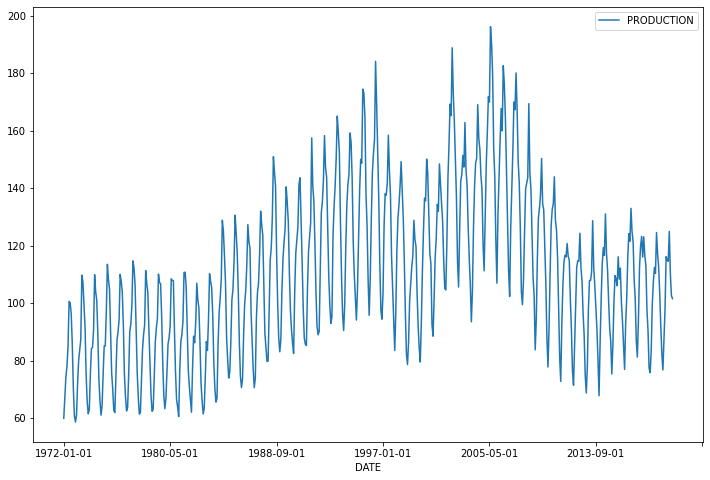

In [11]:
data.plot(figsize = (12,8));

### Train Test Split

In [12]:
test_size = 18

In [13]:
test_index = len(data) - test_size

In [14]:
train = data.iloc[:test_index]

test = data.iloc[test_index:]

In [18]:
train.tail()

,PRODUCTION
DATE,
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899
2018-03-01,107.3152


In [17]:
test.head()

,PRODUCTION
DATE,
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841
2018-07-01,117.2215
2018-08-01,112.6779


### Scaling The Data

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

### Creating Time Series Generator

In [22]:
length = 12

n_features = 1

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
generator = TimeseriesGenerator(scaled_train , scaled_train , length = length , batch_size=1)

In [25]:
X,y = generator[0]

### Note:

here generator is taking 12 inputs from scaled_train to generate 1 output in series

### Creating the Model

In [33]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,LSTM

In [34]:
model = Sequential()

In [35]:
model.add(LSTM(150, input_shape = (length, n_features)))

model.add(Dense(1))

model.compile(optimizer="adam" , loss="mse")

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


### Creating Early Stopping

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor="val_loss" , patience=2)

### Creating Validation Generator

In [39]:
validation_generator = TimeseriesGenerator(scaled_test , scaled_test , length=length , batch_size=1)

### Fitting the Generator

In [40]:
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Sony\AppData\Local\Temp\ipykernel_9460\3986477852.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,


543/543 [==============================] - 8s 9ms/step - loss: 0.0167 - val_loss: 0.0014
Epoch 2/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 3/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0040 - val_loss: 0.0024


### Visualizing The Losses

In [41]:
losses = pd.DataFrame(model.history.history)

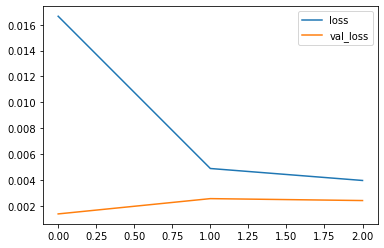

In [43]:
losses.plot();

### Getting and Storing The Predictions

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape((1,length,n_features))

In [45]:
for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


### Inversing The Scale

In [46]:
test_predictions = scaler.inverse_transform(test_predictions)

### Adding True Prediction Column to test

In [47]:
test["PREDICTIONS"] = test_predictions

C:\Users\Sony\AppData\Local\Temp\ipykernel_9460\3447789836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["PREDICTIONS"] = test_predictions


In [48]:
test.head()

,PRODUCTION,PREDICTIONS
DATE,,
2018-04-01,112.4309,114.997680
2018-05-01,110.3544,121.434915
2018-06-01,124.5841,125.078532
2018-07-01,117.2215,121.928219
2018-08-01,112.6779,112.291199


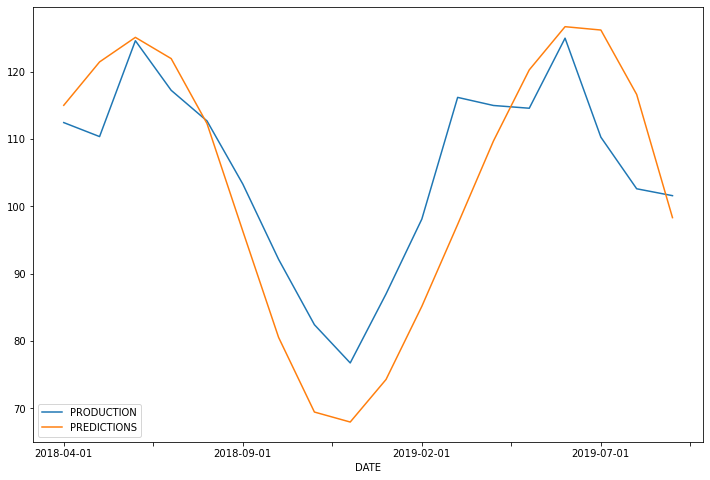

In [49]:
test.plot(figsize = (12,8));

### Evaluating The Model Performance

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
np.sqrt(mean_squared_error(test["PRODUCTION"] , test["PREDICTIONS"]))

9.963055847089095